# 全量数据进行自回归

Mean Squared Error:0.0013970
R2 Score:0.00300
Corr:0.05481

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6722  , p=0.1024  , df_denom=1240, df_num=1
ssr based chi2 test:   chi2=2.6787  , p=0.1017  , df=1
likelihood ratio test: chi2=2.6758  , p=0.1019  , df=1
parameter F test:         F=2.6722  , p=0.1024  , df_denom=1240, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1033  , p=0.9019  , df_denom=1238, df_num=2
ssr based chi2 test:   chi2=0.2072  , p=0.9016  , df=2
likelihood ratio test: chi2=0.2072  , p=0.9016  , df=2
parameter F test:         F=1.4389  , p=0.2376  , df_denom=1238, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1343  , p=0.0941  , df_denom=1236, df_num=3
ssr based chi2 test:   chi2=6.4287  , p=0.0925  , df=3
likelihood ratio test: chi2=6.4122  , p=0.0932  , df=3
parameter F test:         F=3.1054  , p=0.0257  , df_denom=1236, df_num=3

Granger Causality
number of 

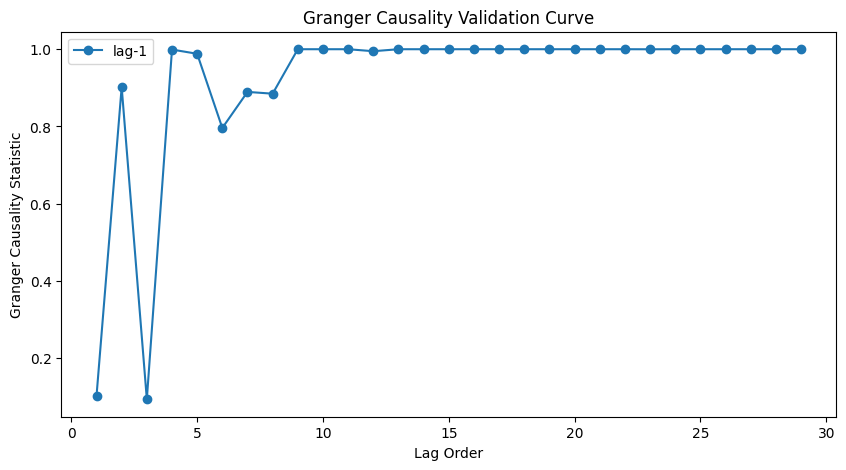

Mean Squared Error:0.0013968
R2 Score:0.00315
Corr:0.05611

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9292  , p=0.0872  , df_denom=1240, df_num=1
ssr based chi2 test:   chi2=2.9363  , p=0.0866  , df=1
likelihood ratio test: chi2=2.9328  , p=0.0868  , df=1
parameter F test:         F=2.9292  , p=0.0872  , df_denom=1240, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2216  , p=0.8013  , df_denom=1237, df_num=2
ssr based chi2 test:   chi2=0.4450  , p=0.8005  , df=2
likelihood ratio test: chi2=0.4449  , p=0.8005  , df=2
parameter F test:         F=0.2216  , p=0.8013  , df_denom=1237, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3425  , p=0.0716  , df_denom=1234, df_num=3
ssr based chi2 test:   chi2=7.0675  , p=0.0698  , df=3
likelihood ratio test: chi2=7.0474  , p=0.0704  , df=3
parameter F test:         F=2.3425  , p=0.0716  , df_denom=1234, df_num=3

Granger Causality
number of 

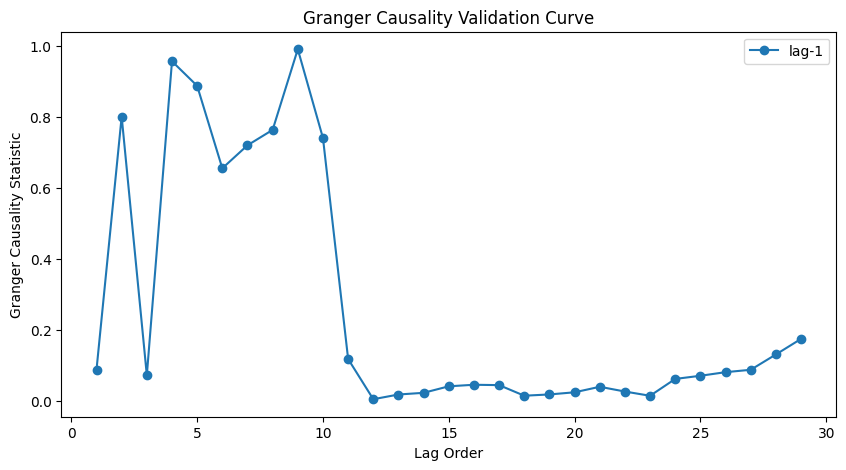



Mean Squared Error:0.0013849
R2 Score:0.01348
Corr:0.11610

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2918  , p=0.5892  , df_denom=1228, df_num=1
ssr based chi2 test:   chi2=0.2925  , p=0.5886  , df=1
likelihood ratio test: chi2=0.2925  , p=0.5886  , df=1
parameter F test:         F=0.2918  , p=0.5892  , df_denom=1228, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0996  , p=0.9052  , df_denom=1225, df_num=2
ssr based chi2 test:   chi2=0.2000  , p=0.9048  , df=2
likelihood ratio test: chi2=0.2000  , p=0.9048  , df=2
parameter F test:         F=0.0996  , p=0.9052  , df_denom=1225, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7565  , p=0.0412  , df_denom=1222, df_num=3
ssr based chi2 test:   chi2=8.3169  , p=0.0399  , df=3
likelihood ratio test: chi2=8.2889  , p=0.0404  , df=3
parameter F test:         F=2.7565  , p=0.0412  , df_denom=1222, df_num=3

Granger Causality
number o

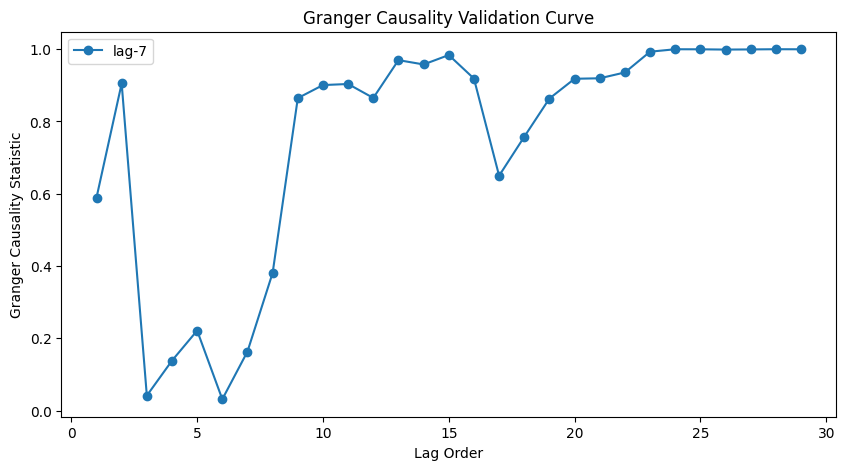

Mean Squared Error:0.0013833
R2 Score:0.01467
Corr:0.12113

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4342  , p=0.5101  , df_denom=1228, df_num=1
ssr based chi2 test:   chi2=0.4352  , p=0.5094  , df=1
likelihood ratio test: chi2=0.4352  , p=0.5095  , df=1
parameter F test:         F=0.4342  , p=0.5101  , df_denom=1228, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0156  , p=0.9846  , df_denom=1225, df_num=2
ssr based chi2 test:   chi2=0.0312  , p=0.9845  , df=2
likelihood ratio test: chi2=0.0312  , p=0.9845  , df=2
parameter F test:         F=0.0156  , p=0.9846  , df_denom=1225, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6928  , p=0.0449  , df_denom=1222, df_num=3
ssr based chi2 test:   chi2=8.1245  , p=0.0435  , df=3
likelihood ratio test: chi2=8.0978  , p=0.0440  , df=3
parameter F test:         F=2.6928  , p=0.0449  , df_denom=1222, df_num=3

Granger Causality
number of 

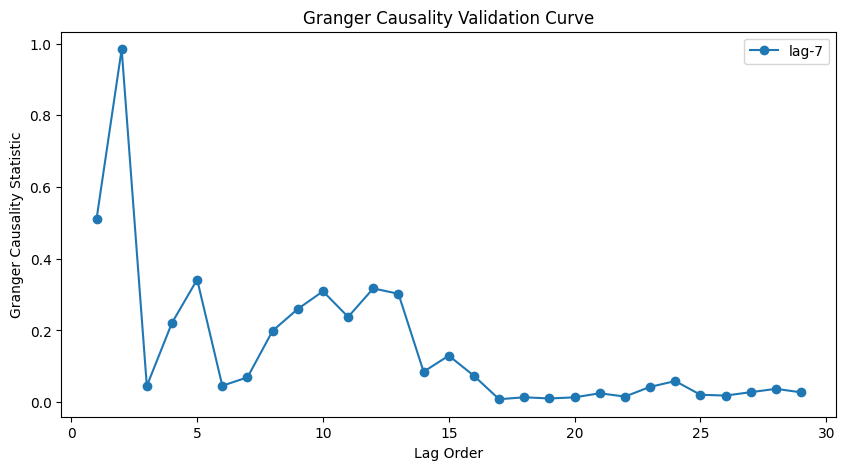



Mean Squared Error:0.0013823
R2 Score:0.02256
Corr:0.15021

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1792  , p=0.2777  , df_denom=1214, df_num=1
ssr based chi2 test:   chi2=1.1821  , p=0.2769  , df=1
likelihood ratio test: chi2=1.1815  , p=0.2770  , df=1
parameter F test:         F=1.1792  , p=0.2777  , df_denom=1214, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1267  , p=0.8810  , df_denom=1211, df_num=2
ssr based chi2 test:   chi2=0.2545  , p=0.8805  , df=2
likelihood ratio test: chi2=0.2545  , p=0.8805  , df=2
parameter F test:         F=0.1267  , p=0.8810  , df_denom=1211, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1359  , p=0.3334  , df_denom=1208, df_num=3
ssr based chi2 test:   chi2=3.4274  , p=0.3303  , df=3
likelihood ratio test: chi2=3.4226  , p=0.3309  , df=3
parameter F test:         F=1.1359  , p=0.3334  , df_denom=1208, df_num=3

Granger Causality
number o

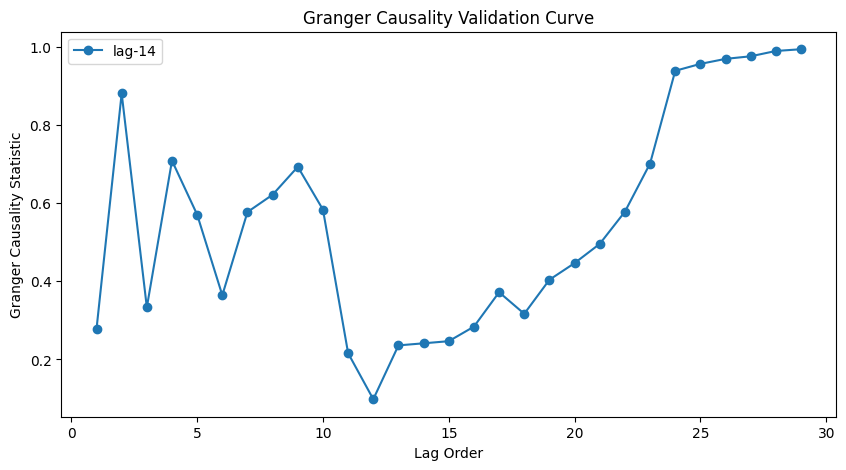

Mean Squared Error:0.0013526
R2 Score:0.04357
Corr:0.20874

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7278  , p=0.3938  , df_denom=1214, df_num=1
ssr based chi2 test:   chi2=0.7296  , p=0.3930  , df=1
likelihood ratio test: chi2=0.7294  , p=0.3931  , df=1
parameter F test:         F=0.7278  , p=0.3938  , df_denom=1214, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3690  , p=0.6915  , df_denom=1211, df_num=2
ssr based chi2 test:   chi2=0.7411  , p=0.6903  , df=2
likelihood ratio test: chi2=0.7409  , p=0.6904  , df=2
parameter F test:         F=0.3690  , p=0.6915  , df_denom=1211, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1844  , p=0.3144  , df_denom=1208, df_num=3
ssr based chi2 test:   chi2=3.5738  , p=0.3113  , df=3
likelihood ratio test: chi2=3.5685  , p=0.3120  , df=3
parameter F test:         F=1.1844  , p=0.3144  , df_denom=1208, df_num=3

Granger Causality
number of 

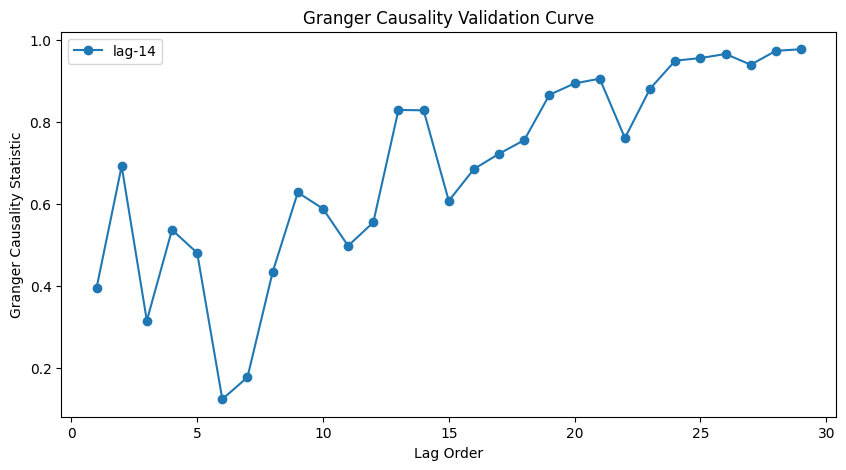

In [15]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import numpy as np
scaler = MinMaxScaler()
def test(lags,data_path, add_sentiment):
    # print(data_path)
    # 读取CSV文件
    data = pd.read_csv(data_path)

    # 加入发推量
    data[['count']]= scaler.fit_transform(data[['count']])
    data['metrics'] = data['metrics'] * data['count']

    # data['Close'] = data['Close'].pct_change()
    data['Close'] = np.log(data['Close']) - np.log(data['Close'].shift(1))
    data['metrics'] = data['metrics'].diff()

    



    data = data[data['Close'].notna()]
    # 提取"Close"和"metrics"列数据

    price = data["Close"]
    metrics = data["metrics"]
    # lags = 7
    price = price[lags:]

    # 创建滞后外生变量的数据集
    lagged_metrics = pd.DataFrame()
    for lag in range(1, lags+1):
        lagged_metrics[f"metrics_lag{lag}"] = metrics.shift(lag)

    # 将滞后外生变量和原始数据合并
    exog_data = pd.concat([lagged_metrics], axis=1)
    exog_data = exog_data[exog_data[f'metrics_lag{lags}'].notna()]

    # print(exog_data)
    # print(price)


    # time = 500
    # train_data = price[:-time]
    # test_data = price[-time:]
    # train_sentiment = exog_data[:-time]
    # test_sentiment = exog_data[-time:]
    train_data = price
    train_sentiment = exog_data
    test_data = price
    test_sentiment = exog_data
    # print(len(train_data),len(train_sentiment))
    # print(len(test_data),len(test_sentiment))

    # print(test_data.values)
    # 创建并拟合AutoReg模型
    # add_sentiment = 1
    if not add_sentiment:
        model = AutoReg(train_data.values, lags=lags)
    else:
        model = AutoReg(train_data.values, lags=lags,exog=train_sentiment.values)
    model_fit = model.fit()

    # 预测未来100个时间点的股价
    if add_sentiment:
        # predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1,exog_oos=test_sentiment.values)
        predictions = model_fit.predict(start=lags, end=len(train_data)-1,exog_oos=test_sentiment[lags:].values)
    else:
        # predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
        predictions = model_fit.predict(start=lags, end=len(train_data)-1)
    # 计算预测结果的均方误差
    # print(predictions.values)
    mse = mean_squared_error(test_data[lags:], predictions)
    print('Mean Squared Error:{:.7f}'.format(mse))
    # 计算R2
    r2 = r2_score(test_data[lags:], predictions)
    print('R2 Score:{:.5f}'.format(r2))
    # 计算Corr
    correlation = np.corrcoef(test_data[lags:], predictions)[0, 1]
    print('Corr:{:.5f}'.format(correlation))
    # 绘制预测结果

    # plt.plot(train_data.index, train_data.values, label='Train Data')
    # plt.plot(test_data[lags:].index, test_data[lags:].values, label='Test Data')
    # plt.plot(test_data[lags:].index, predictions, label='Predictions')
    # plt.legend()
    # plt.xlabel('Date')
    # plt.ylabel('Close Price')
    # plt.title('Stock Price Prediction')
    # plt.show()
    
    # granger因果检验
    plt.figure(figsize=(10, 5))
    df = pd.DataFrame({"source": predictions, "target": test_data[lags:]})
    results = []
    for maxlag in range(1, 30):
        result = grangercausalitytests(df[['target','source']], maxlag=[maxlag])
        results.append(result[maxlag][0]['ssr_ftest'][1])
    plt.plot(np.arange(1, 30), results, marker='o',label=f'lag-{lag}')
    plt.xlabel('Lag Order')
    plt.ylabel('Granger Causality Statistic')
    plt.title('Granger Causality Validation Curve')
    plt.legend()
    plt.show()


data_path = "combined/sentiment_all_feature.csv"

for window in [1,7,14]:

    test(window,data_path,0)
    test(window,data_path,1)
    print('\n')
# test(7,data_path,0)
# test(7,data_path,1)
# test(14,data_path,0)
# test(14,data_path,1)



# 线性回归

In [ ]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import torch.nn.init as init
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

def regression(data:pd.DataFrame,window,time):
    data = data[data['Close'].notna()]
    data = data[data['metrics'].notna()]


    tensor_list = [data['metrics'].values[i:i+window] for i in range(len(data) - window-time)]
    X = np.array(tensor_list)
    # X = torch.from_numpy(X)

    tensor_list = [data['Close'].values[i:i+1] for i in range(window,len(data)-time)]
    Y = np.array(tensor_list)
    # Y = torch.from_numpy(Y)


    # tensor_list = [df['metrics'].values[i:i+window] for i in range(len(df) - window-time,len(df) - window)]
    # X_test = np.array(tensor_list)
    # # X_test = torch.from_numpy(X_test)

    # tensor_list = [df['Close'].values[i:i+1] for i in range(len(df)-time,len(df))]
    # Y_test = np.array(tensor_list)
    # # Y_test = torch.from_numpy(Y_test)


    print(window,len(X),len(Y))
    # print(len(X_test),len(Y_test))

    # 创建线性回归模型
    model = LinearRegression()

    # 拟合模型
    print(X.shape,Y.shape)
    model.fit(X, Y)

    # 打印模型系数
    print('模型系数:', model.coef_)  # 斜率
    print('截距:', model.intercept_)  # 截距




    predicted_y = model.predict(X)
    # print(predicted_y)


    print(np.corrcoef(Y.ravel(), predicted_y.ravel())[0, 1])

    # 
    plt.figure(figsize=(10, 5))
    test_data = pd.DataFrame({"source": predicted_y.ravel(), "target": Y.ravel()})
    results = []
    for maxlag in range(1, 30):
        result = grangercausalitytests(test_data[['target','source']], maxlag=[maxlag])
        # print(result)
        results.append(result[maxlag][0]['ssr_ftest'][1])
    plt.plot(np.arange(1, 30), results, marker='o',label=f'lag-{window}')
    plt.xlabel('Lag Order')
    plt.ylabel('Granger Causality Statistic')
    plt.title('Granger Causality Validation Curve')
    plt.legend()
    plt.show()




scaler = MinMaxScaler()
df = pd.read_csv('combined/sentiment_all_feature.csv')
# fear = pd.read_csv('Fear_and_Greed_Index.csv')
# df = pd.merge(df,fear,left_on='date',right_on='timestamp',how='left')
# df['metrics'] = df['metrics']

# print(df)


# df['Close'] = df['Close'].pct_change()

# 加入发推量
df[['count']]= scaler.fit_transform(df[['count']])
df['metrics'] = df['metrics'] * df['count']

df['Close'] = np.log(df['Close']) - np.log(df['Close'].shift(1))





for diff_type in ['diff']:
    if diff_type == 'pct_change':
        df[['metrics']]= scaler.fit_transform(df[['metrics']])
        df = df[df['metrics']!=0]
        # print(df[df['metrics']==0])
        df['metrics'] = df['metrics'].pct_change()
    elif diff_type == 'diff':
        df['metrics'] = df['metrics'].diff()
    elif diff_type == 'log_return':
        df[['metrics']]= scaler.fit_transform(df[['metrics']])
        
        df = df[df['metrics']!=0]
        df['metrics'] = np.log(df['metrics']) - np.log(df['metrics'].shift(1))
    else:
        df['metrics'] = df['metrics']
    
    for window in [7]:
        regression(df.copy(), window,0)
    # res,param,corrs = regression(df, window,0)
    # import matplotlib.pyplot as plt
    # plt.plot(corrs[1], corrs[0],label='Corr')
    # plt.xlabel('Epoth')
    # plt.ylabel('Test Corr')
    # plt.legend()
    # plt.show()
    # print("{};{};{};{}".format(window, diff_type, res, param))

# 因果检验

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

scaler = MinMaxScaler()
data = pd.read_csv('combined/sentiment_mean.csv')

data['metrics'] =  data['metrics']
data['value'] = data['Close']

# window_size = 3 # 窗口大小
# data['metrics'] = data['metrics'].rolling(window_size).mean()



def show_test(data, lag,diff_type):


    
    data['metrics'] = data['metrics'].shift(lag)
    
    # window_size = 3 # 窗口大小
    # data['metrics'] = data['metrics'].rolling(window_size).mean()
    # data[['metrics']]= scaler.fit_transform(data[['metrics']])
    # data['metrics_return'] = data['metrics'].pct_change()
    # data = data[data['metrics_return'] < 9999]

    # data['value_return'] = data['value'].pct_change()
    # data['value_return'] = np.log(data['value']) - np.log(data['value'].shift(1))
    # data = data[data['value_return'] < 9999]


    if diff_type[0] == 'pct_change':
        data[['metrics']]= scaler.fit_transform(data[['metrics']])
        data = data[data['metrics']!=0]
        data['metrics_return'] = data['metrics'].pct_change()
    elif diff_type[0] == 'diff':
        data['metrics_return'] = data['metrics'].diff()
    elif diff_type[0] == 'log_return':
        data[['metrics']]= scaler.fit_transform(data[['metrics']])
        data = data[data['metrics']!=0]
        data['metrics_return'] = np.log(data['metrics']) - np.log(data['metrics'].shift(1))

    if diff_type[1] == 'pct_change':
        data['value_return'] = data['value'].pct_change()
    elif diff_type[1] == 'log_return':
        data['value_return'] = np.log(data['value']) - np.log(data['value'].shift(1))
    elif diff_type[1] == 'diff':
        data['value_return'] = data['value'].diff()



    
    start = '2020-01-02'
    end = '2023-05-30'
    data['date'] = pd.to_datetime(data['date'])
    data = data[(data['date']>= pd.Timestamp(start)) & (data['date'] <= pd.Timestamp(end))]
    
    data = data[data['metrics_return'].notna()]
    data = data[data['value_return'].notna()]


    source = 'metrics_return'
    target = 'value_return'

    print(data[source].corr(data[target]))

    # 创建空的列表来存储结果
    results = []

    # print(len(data[source]))

    # 尝试不同的滞后阶数并执行格兰杰因果性分析
    for lag2 in range(1, 14):
        result = grangercausalitytests(data[[target, source]], maxlag=[lag2])
        # result = grangercausalitytests(data[[source, target]], maxlag=[lag])
        # print(result)
        results.append(result[lag2][0]['ssr_ftest'][1])

    # 绘制验证曲线


    # print(min(results))
    lags = np.arange(1, 14)
    

    # print(results)
    return lags, results
    




# result_map = {}

# plt.figure(figsize=(10, 5))
# for lag in range(10):
#     lags, results = show_test(data.copy(), lag, ['pct_change','log_return'])
#     plt.plot(lags, results, marker='o',label=f'lag-{lag}')
#     result_map[lag] = min(results)
# plt.xlabel('Lag Order')
# plt.ylabel('Granger Causality Statistic')
# plt.title('Granger Causality Validation Curve')
# plt.legend()
# plt.show()
# print(result_map)

for diff_type1 in ['pct_change','diff','log_return']:
    for diff_type2 in ['pct_change','diff','log_return']:
# for diff_type1 in ['pct_change']:
#     for diff_type2 in ['pct_change']:
        diff_type = []
        diff_type.append(diff_type1)
        diff_type.append(diff_type2)
        result_map = {}
        plt.figure(figsize=(10, 5))
        for lag in range(5):
            lags, results = show_test(data.copy(), lag, diff_type)
            plt.plot(lags, results, marker='o',label=f'lag-{lag}')
            result_map[lag] = min(results)


        plt.xlabel('Lag Order')
        plt.ylabel('Granger Causality Statistic')
        plt.title('Granger Causality Validation Curve')
        plt.legend()
        plt.show()

        print(diff_type, result_map)
        
    


In [ ]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# 读取CSV文件
data = pd.read_csv("sentiment.csv")

# 提取"Close"和"metrics"列数据


def test(lags,data):
    price = data["Close"]
    metrics = data["metrics"]
    # lags = 7
    price = price[lags:]

    # 创建滞后外生变量的数据集
    lagged_metrics = pd.DataFrame()
    for lag in range(1, lags+1):
        lagged_metrics[f"metrics_lag{lag}"] = metrics.shift(lag)

    # 将滞后外生变量和原始数据合并
    exog_data = pd.concat([lagged_metrics], axis=1)
    exog_data = exog_data[exog_data[f'metrics_lag{lags}'].notna()]

    # print(exog_data)
    # print(price)


    time = 500
    train_data = price[:-time]
    test_data = price[-time:]
    train_sentiment = exog_data[:-time]
    test_sentiment = exog_data[-time:]


    # print(len(train_data),len(train_sentiment))
    # print(len(test_data),len(test_sentiment))

    # print(test_data.values)
    # 创建并拟合AutoReg模型
    add_sentiment = 0
    if not add_sentiment:
        model = AutoReg(train_data.values, lags=lags)
    else:
        model = AutoReg(train_data.values, lags=lags,exog=train_sentiment.values)
    model_fit = model.fit()


    # 预测未来100个时间点的股价
    if add_sentiment:
        predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1,exog_oos=test_sentiment.values)
    else:
        predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    # 计算预测结果的均方误差
    # print(predictions.values)
    mse = mean_squared_error(test_data, predictions)
    print('Mean Squared Error:', mse)
    # 计算R2
    r2 = r2_score(test_data, predictions)
    print('R2 Score:', r2)
    # 计算Corr
    correlation = np.corrcoef(test_data, predictions)[0, 1]
    print(correlation)
    # 绘制预测结果

    # plt.plot(train_data.index, train_data.values, label='Train Data')
    plt.plot(test_data.index, test_data.values, label='Test Data')
    plt.plot(test_data.index, predictions, label='Predictions')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Stock Price Prediction')
    # plt.show()


    add_sentiment = 1
    if not add_sentiment:
        model = AutoReg(train_data.values, lags=lags)
    else:
        model = AutoReg(train_data.values, lags=lags,exog=train_sentiment.values)
    model_fit = model.fit()


    # 预测未来100个时间点的股价
    if add_sentiment:
        predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1,exog_oos=test_sentiment.values)
    else:
        predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    # 计算预测结果的均方误差
    # print(predictions.values)
    mse = mean_squared_error(test_data, predictions)
    print('Mean Squared Error:', mse)
    # 计算R2
    r2 = r2_score(test_data, predictions)
    print('R2 Score:', r2)
    # 计算Corr
    correlation = np.corrcoef(test_data, predictions)[0, 1]
    print(correlation)
    # 绘制预测结果
    # plt.plot(train_data.index, train_data.values, label='Train Data')
    # plt.plot(test_data.index, test_data.values, label='Test Data')
    plt.plot(test_data.index, predictions, label='Predictions')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('BTC Price Prediction')
    # plt.show()
test(7,data.copy())

In [ ]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
# 读取CSV文件
data = pd.read_csv("sentiment_.csv")
data['Close'] = data['Close'].pct_change()



# 加入发推量
# data[['count']]= scaler.fit_transform(data[['count']])
# data['metrics'] = data['metrics'] * df['count']

data[['metrics']]= scaler.fit_transform(data[['metrics']])
data = data[data['metrics']!=0]
data['metrics'] = data['metrics'].pct_change()

data = data[data['Close'].notna()]
data = data[data['metrics'].notna()]
# 提取"Close"和"metrics"列数据
data = data.reset_index(drop=True)
# print(data)



def test(data,lags,time):
    price = data["Close"]
    metrics = data['metrics']



    # lags = 7
    price = price[lags:]

    # 创建滞后外生变量的数据集
    lagged_metrics = pd.DataFrame()
    for lag in range(1, lags+1):
        lagged_metrics[f"metrics_lag{lag}"] = metrics.shift(lag)

    # 将滞后外生变量和原始数据合并
    exog_data = pd.concat([lagged_metrics], axis=1)
    exog_data = exog_data[exog_data[f'metrics_lag{lags}'].notna()]


    # exog_data = exog_data[lags:]

    # print(exog_data)
    # print(price)


    # time = 800
    train_data = price[:-time]
    test_data = price[-time:]
    train_sentiment = exog_data[:-time]
    test_sentiment = exog_data[-time:]


    add_sentiment = 1
    # print(len(train_data),len(train_sentiment))
    # 创建并拟合AutoReg模型
    if add_sentiment:
        model = AutoReg(train_data.values, lags=lags, exog=train_sentiment.values)
    else:
        model = AutoReg(train_data.values, lags=lags)
    model_fit = model.fit()
    # print(model_fit.params)

    # 预测未来100个时间点的股价
    if add_sentiment:
        predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1,exog_oos=test_sentiment.values)
    else:
        predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    # 计算预测结果的均方误差
    # print(predictions.values)
    mse = mean_squared_error(test_data, predictions)
    # print('Mean Squared Error:', mse)
    # 计算R2
    r2 = r2_score(test_data, predictions)
    # print('R2 Score:', r2)
    # 计算Corr
    correlation1 = np.corrcoef(test_data, predictions)[0, 1]
    # print('Corr:',correlation1)
    # 绘制预测结果
    # plt.plot(train_data.index, train_data.values, label='Train Data')
    # plt.plot(test_data.index, test_data.values, label='Test Data')
    # plt.plot(test_data.index, predictions, label='Predictions')
    # plt.legend()
    # plt.xlabel('Date')
    # plt.ylabel('Close Price')
    # plt.title('Stock Price Prediction')
    # plt.show()


    add_sentiment = 0
    # print(len(train_data),len(train_sentiment))
    # 创建并拟合AutoReg模型
    if add_sentiment:
        model = AutoReg(train_data.values, lags=lags, exog=train_sentiment.values)
    else:
        model = AutoReg(train_data.values, lags=lags)
    model_fit = model.fit()


    # 预测未来100个时间点的股价
    if add_sentiment:
        predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1,exog_oos=test_sentiment.values)
    else:
        predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    # 计算预测结果的均方误差
    # print(predictions.values)
    mse = mean_squared_error(test_data, predictions)
    # print('Mean Squared Error:', mse)
    # 计算R2
    r2 = r2_score(test_data, predictions)
    # print('R2 Score:', r2)
    # 计算Corr
    correlation2 = np.corrcoef(test_data, predictions)[0, 1]
    # print('Corr:',correlation2)
    # 绘制预测结果
    # plt.plot(train_data.index, train_data.values, label='Train Data')
    # plt.plot(test_data.index, test_data.values, label='Test Data')
    # plt.plot(test_data.index, predictions, label='Predictions')
    # plt.legend()
    # plt.xlabel('Date')
    # plt.ylabel('Close Price')
    # plt.title('Stock Price Prediction')
    # plt.show()
    return correlation1,correlation2
# corr1,corr2 = test(data.copy(),7,100)
corr1_l = []
corr2_l = []
for i in range(100,1200,100):
    corr1,corr2 = test(data.copy(),7,i)
    corr1_l.append(corr1)
    corr2_l.append(corr2)
    print(corr1,corr2)
plt.plot(range(100,1200,100), corr1_l, label='add sentiment')
plt.plot(range(100,1200,100), corr2_l, label='origin')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction')
plt.show()